In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import circulant
from scipy.integrate import solve_ivp

# Problem 1

The Integrator function requires that we manually code each case that we want to have implemented, as per instruction by the course staff, only ythe nessasary functions required for Problem 2 have been implemented.

In [2]:
# Periodic Operator
def D_operator_periodic(N,L,R,a):
    first_row = np.zeros(N); first_row[0:L+R+1] = a; first_row = np.roll(first_row,-L)
    return np.array(circulant(first_row)).transpose()

def D_operator_nonperiodic(N, L, R, a):
    D = np.zeros((N, N))

    for i in range(L, N-R):
        D[i, i-L:i+R+1] = a

    for i in range(L):
        D[i, :L+R+1] = np.roll(a, -i)

    for i in range(N-R, N):
        D[i, N-L-R-1:] = np.roll(a, N-i-1)

    return D

# Functor for the 1D advection equation
def LinearAdv1D(t,U,D):
    # Initialize velocity
    a = 1
    # Return F(t,U)
    return (-a*D)@U

# General integrator function
def Integrator(periodic,operator,problem,L,T,Nx,Nt,U0):
  # Initialize spatial domain
    x  = np.linspace(0, L, Nx, endpoint=(not periodic))
    dx = x[1] - x[0]

  # Initialize temporal domain
    t  = np.linspace(0, T, Nt, endpoint=True)

  # Construct spatial matrix operator
    match (operator,periodic):
        # periodic
        case ('ForwardOrder1FirstDeriv',True):
            D = D_operator_periodic(Nx, 0, 1,[-1/dx,1/dx])
        case ('BackwardOrder1FirstDeriv',True):
            D = D_operator_periodic(Nx, 1, 0, [-1/dx,1/dx])
        case ('CentralOrder2SecondDeriv', True):
            D = D_operator_periodic(Nx, 1, 1, [-1/(2*dx), 0, 1/(2*dx)])
        case ('BackwardOrder3ThirdDeriv', True):
            D = D_operator_periodic(Nx, 2, 1, [1/(6*dx), -6/(6*dx), 3/(6*dx), 2/(6*dx)])
        case ('CentralOrder4FourthDeriv', True):
            D = D_operator_periodic(Nx, 2, 2, [1/(12*dx), -8/(12*dx), 0, 8/(12*dx), -1/(12*dx)])
        # non-periodic
        case ('ForwardOrder1FirstDeriv',False):
            D = D_operator_nonperiodic(Nx,0,1,[-1/dx,1/dx])
        case ('BackwardOrder1FirstDeriv',False):
            D = D_operator_nonperiodic(Nx,1,0,[-1/dx,1/dx])
        case ('CentralOrder2SecondDeriv', False):
            D = D_operator_nonperiodic(Nx, 1, 1, [-1/(2*dx), 0, 1/(2*dx)])
        case ('BackwardOrder3ThirdDeriv', False):
            D = D_operator_nonperiodic(Nx, 3, 0, [1/(6*dx), -6/(6*dx), 3/(6*dx), 2/(6*dx)])
        case ('CentralOrder4FourthDeriv', False):
            D = D_operator_nonperiodic(Nx, 2, 2, [1/(12*dx), -8/(12*dx), 0, 8/(12*dx), -1/(12*dx)])
        case _:
            raise Exception("The %s operator '%s' is not yet implement!" % ('periodic' if periodic else 'non-periodic', operator))

  # Solve and return solutions!
    match problem:
        case 'LinearAdv1D':
      # Solve initial value problem; see documentation at:
      # https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
            sol = solve_ivp(LinearAdv1D, [0, T], U0, args=(D,), t_eval=t, rtol=1.0e-6, atol=1.0e-6)
      # Transpose solution vector so that U has the format (Nt x Nx)
            U = sol.y.transpose()
      # Return outputs
            return t, U, D
        case _:
            raise Exception("The case '%s' is not yet implement!" % problem)

# Problem 2

[[ 50.   0.   0. ...   0.   0. -50.]
 [-50.  50.   0. ...   0.   0.   0.]
 [  0. -50.  50. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  50.   0.   0.]
 [  0.   0.   0. ... -50.  50.   0.]
 [  0.   0.   0. ...   0. -50.  50.]]


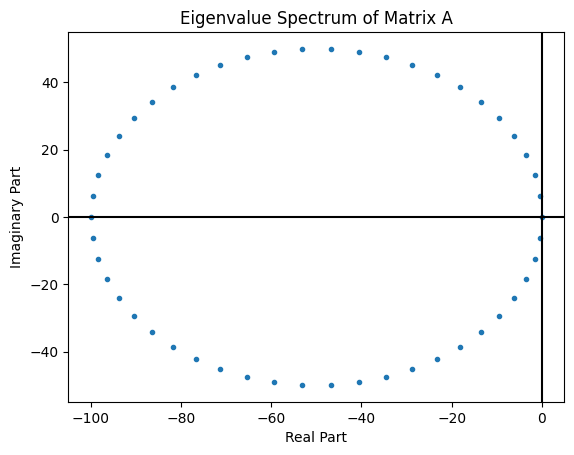

Text(0.5, 1.0, 'Exact vs Numerical Solutions')

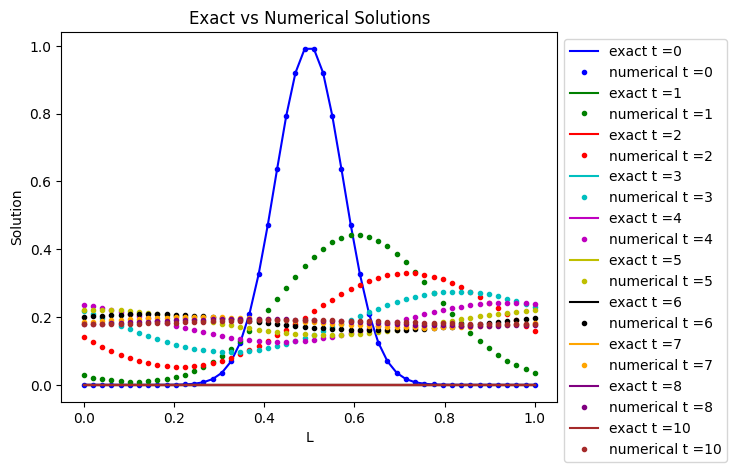

In [3]:
xs = np.linspace(0, 1, 50)

U0 = np.exp((-(xs - 0.5)**2) / (2 * (3/40)**2))

t, U, D = Integrator(True,'BackwardOrder1FirstDeriv','LinearAdv1D',1,10,50,10, U0)

print(D)

a = 1.0
A = -a * D

eigenvalues1 = np.linalg.eigvals(A)

# Plot the eigenvalue spectrum
#plt.figure(figsize=(8, 6))
plt.plot(np.real(eigenvalues1), np.imag(eigenvalues1),'.')
plt.title('Eigenvalue Spectrum of Matrix A')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.show()


colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
v = 0
for i in t:
    Uexact = np.exp(-((xs-a * i)-1/2)**2 / (2*(3/40)**2))
    plt.plot(xs, Uexact, label = 'exact t =' + str(int(i)), color=colors[v])
    plt.plot(xs, U[v], '.', label = 'numerical t =' + str(int(i)), color=colors[v])
    v+=1

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('L')
plt.ylabel('Solution')
plt.title('Exact vs Numerical Solutions')

Looking at the Eigenvalue Spectrum, we see that the upwind first order scheme has real parts of its eigenvalues that are negative. This displays artificial decay and therefore is dissipative. The eigenvalues are all on the left of the axis in the complex plane, which shows that the solution is stable.

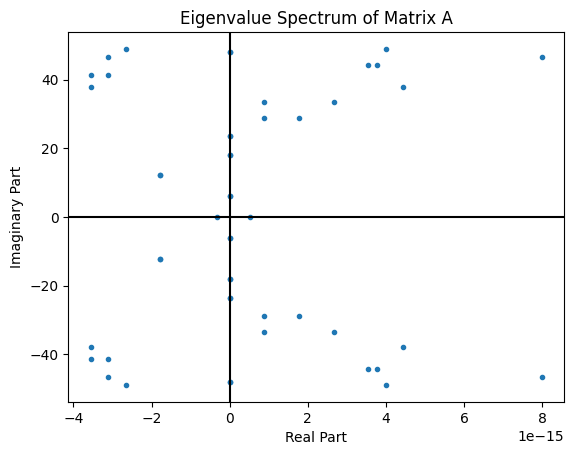

Text(0.5, 1.0, 'Exact vs Numerical Solutions')

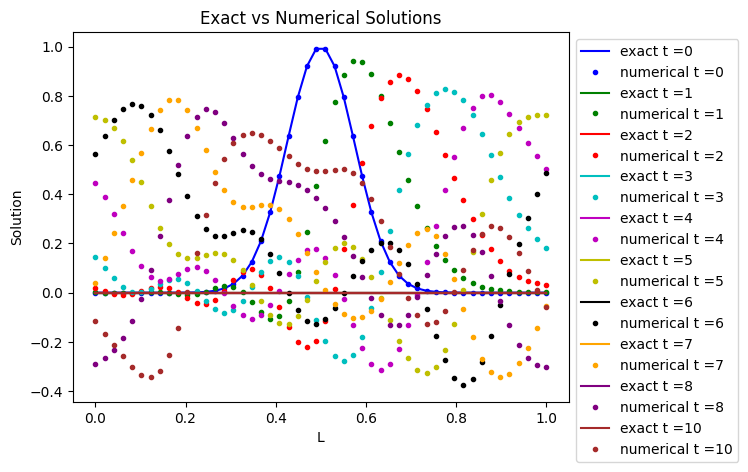

In [4]:
xs = np.linspace(0, 1, 50)
U0 = np.exp((-(xs - (1/2))**2)/(2 * (3 / 40) **2))



t, U, D = Integrator(True,'CentralOrder2SecondDeriv','LinearAdv1D', 1, 10, 50, 10, U0)

x  = np.linspace(0, 1, 50)
dx = x[1] - x[0]
D1 = D_operator_periodic(50, 1, 1, [-1/(2*dx), 0, 1/(2*dx)])

a = 1
A = -a * D1

eigenvalues2 = np.linalg.eigvals(A)

# Plot the eigenvalue spectrum
#plt.figure(figsize=(8, 6))
plt.plot(np.real(eigenvalues2), np.imag(eigenvalues2),'.')
plt.title('Eigenvalue Spectrum of Matrix A')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.show()

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
v = 0
for i in t:
    Uexact = np.exp(-((xs-a * i)-1/2)**2 / (2*(3/40)**2))
    plt.plot(xs, Uexact, label = 'exact t =' + str(int(i)), color=colors[v])
    plt.plot(xs, U[v], '.', label = 'numerical t =' + str(int(i)), color=colors[v])
    v+=1

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('L')
plt.ylabel('Solution')
plt.title('Exact vs Numerical Solutions')

Because all of the eigenvalues are purely imaginary, as the Real Part of the eigenvalue is measured in extrememly small quantities ($10^{-15}$), we can see from the Eigenvalue Spectrum that there are only imaginary parts to the eignvalues. This means that the system is stable and there is no dissipation.

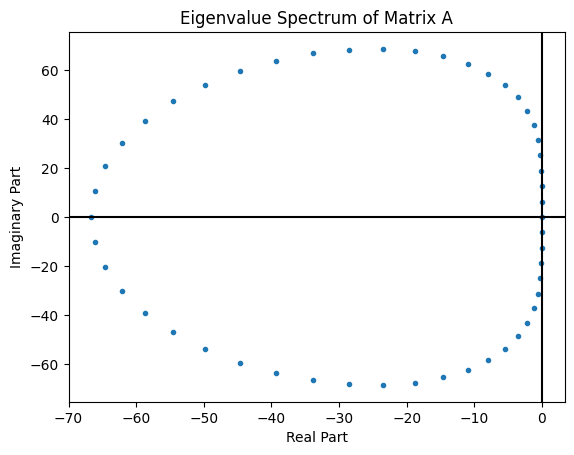

Text(0.5, 1.0, 'Exact vs Numerical Solutions')

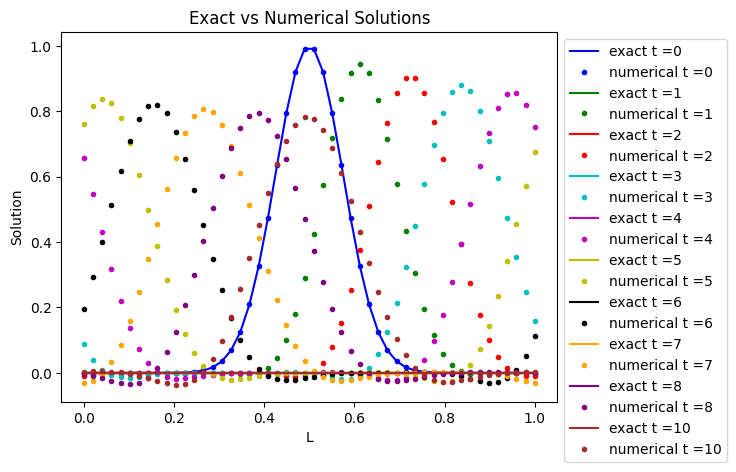

In [5]:
xs = np.linspace(0, 1, 50)
U0 = np.exp((-(xs - (1/2))**2)/(2 * (3 / 40) **2))



t, U, D = Integrator(True,'BackwardOrder3ThirdDeriv','LinearAdv1D', 1, 10, 50, 10, U0)

a = 1
A = -a * D

eigenvalues3 = np.linalg.eigvals(A)

# Plot the eigenvalue spectrum
#plt.figure(figsize=(8, 6))
plt.plot(np.real(eigenvalues3), np.imag(eigenvalues3),'.')
plt.title('Eigenvalue Spectrum of Matrix A')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.show()

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
v = 0
for i in t:
    Uexact = np.exp(-((xs-a * i)-1/2)**2 / (2*(3/40)**2))
    plt.plot(xs, Uexact, label = 'exact t =' + str(int(i)), color=colors[v])
    plt.plot(xs, U[v], '.', label = 'numerical t =' + str(int(i)), color=colors[v])
    v+=1

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('L')
plt.ylabel('Solution')
plt.title('Exact vs Numerical Solutions')

Similar to the first order upwind scheme, the third order upwind scheme has negative real parts in its eigenvalues, which indicates to us that there will be artificial decay, causing it to be dissipative. As all the eigenvalues are on the left of the imaginary axis in the complex plane, the solution is also known to be stable. The dissapation of the first order scheme is more prominent than the third order scheme.

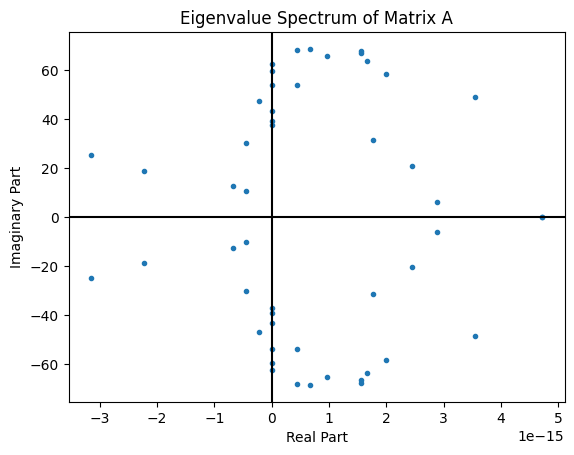

Text(0.5, 1.0, 'Exact vs Numerical Solutions')

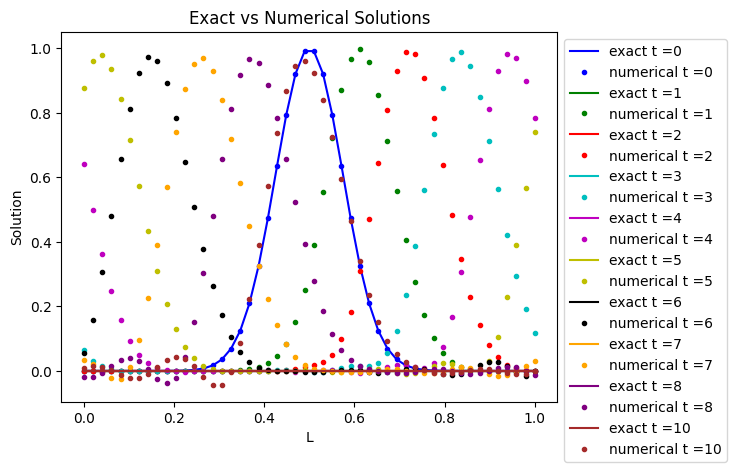

In [6]:
xs = np.linspace(0, 1, 50)
U0 = np.exp((-(xs - (1/2))**2)/(2 * (3 / 40) **2))



t, U, D = Integrator(True,'CentralOrder4FourthDeriv','LinearAdv1D', 1, 10, 50, 10, U0)

a = 1
A = -a * D

eigenvalues4 = np.linalg.eigvals(A)

# Plot the eigenvalue spectrum
plt.plot(np.real(eigenvalues4), np.imag(eigenvalues4),'.')
plt.title('Eigenvalue Spectrum of Matrix A')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.show()


colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
v = 0
for i in t:
    Uexact = np.exp(-((xs-a * i)-1/2)**2 / (2*(3/40)**2))
    plt.plot(xs, Uexact, label = 'exact t =' + str(int(i)), color=colors[v])
    plt.plot(xs, U[v], '.', label = 'numerical t =' + str(int(i)), color=colors[v])
    v+=1

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('L')
plt.ylabel('Solution')
plt.title('Exact vs Numerical Solutions')

Because all of the eigenvalues are purely imaginary, as the Real Part of the eigenvalue is measured in extrememly small quantities ($10^{-15}$), we can see from the Eigenvalue Spectrum that there are only imaginary parts to the eignvalues. This means that the system is stable and there is no dissipation. The periodic domain can also be seen repeating as the numeric solution continues.

# Problem 3

In [7]:
kdx = np.linspace(0, np.pi, 50, endpoint = True)

To derive the analytical expression of the modified wavenumber $ \kappa^{*}$ using Fourier error analysis.

For the first order upwind scheme,

$$\frac{\delta u}{\delta x} = \frac{u_i - u_{i-1}}{\Delta x}$$

We substitute

$$ u_i = e^{ikx} $$

to get

$$ \frac{\delta u}{\delta x} = \frac{e^{ikx_i} - e^{ikx_{n-1}}}{\Delta x} = \frac{e^{ikx} - e^{ik(x - \Delta x)}}{\Delta x} $$

And rearrange with algebra to get

$$ \frac{\delta u}{\delta x} = e^{ikx}\frac{1 - e^{ik\Delta x}}{\Delta x} $$

Using the Euler Formula and subbing in:

$$ \frac{\delta u}{\delta x} = e^{ikx}\frac{1-\cos(k\Delta x) + i \sin(k \Delta x)}{\Delta x} = i (\frac{1-\cos(k\Delta x) + i \sin(k \Delta x)}{i \Delta x})e^{ikx} $$

Therefore the modified wave number is:

$$ k^* = (\frac{1-\cos(k\Delta x) + i \sin(k \Delta x)}{i \Delta x}) $$


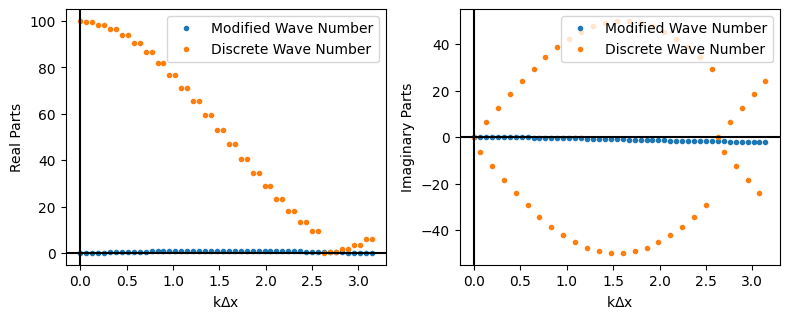

In [8]:
k = (1-np.cos(kdx) + 1j*np.sin(kdx)) / (1j)
kN = - eigenvalues1

fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax1 = fig.add_subplot(221)
ax1.plot(kdx, np.real(k),'.', label = 'Modified Wave Number')
ax1.plot(kdx, np.real(kN), '.' ,label = 'Discrete Wave Number')

ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')


ax2 = fig.add_subplot(222)
ax2.plot(kdx, np.imag(k),'.',label = 'Modified Wave Number')
ax2.plot(kdx, np.imag(kN), '.',label = 'Discrete Wave Number')
ax2.axhline(y=0, color='k')
ax2.axvline(x=0, color='k')

ax1.set_xlabel('k$\Delta$x')
ax1.set_ylabel('Real Parts')
ax2.set_xlabel('k$\Delta$x')
ax2.set_ylabel('Imaginary Parts')
ax1.legend()
ax2.legend()

But because the discrete values of the modified wave number don't exactly align with what we were asked to do for the second plots because the discrete modified wave numbers are not in the same domain as $k\Delta x$. To fix this and provide better visual aid, a scaling factor of $16 \pi$ is used in order to achieve a similar amplitude

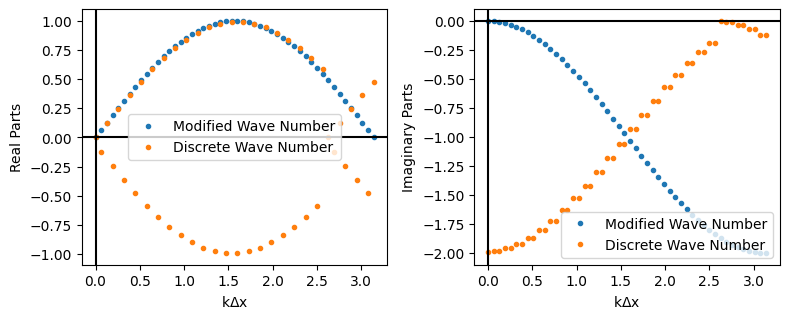

In [9]:
k = (1-np.cos(kdx) + 1j*np.sin(kdx)) / (1j)
kN = - eigenvalues1 / (16 * np.pi  * 1j)

fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax1 = fig.add_subplot(221)
ax1.plot(kdx, np.real(k),'.', label = 'Modified Wave Number')
ax1.plot(kdx, np.real(kN), '.' ,label = 'Discrete Wave Number')

ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')


ax2 = fig.add_subplot(222)
ax2.plot(kdx, np.imag(k),'.',label = 'Modified Wave Number')
ax2.plot(kdx, np.imag(kN), '.',label = 'Discrete Wave Number')
ax2.axhline(y=0, color='k')
ax2.axvline(x=0, color='k')

ax1.set_xlabel('k$\Delta$x')
ax1.set_ylabel('Real Parts')
ax2.set_xlabel('k$\Delta$x')
ax2.set_ylabel('Imaginary Parts')
ax1.legend()
ax2.legend()

For the second order central scheme:

$$ \frac{\delta u}{\delta x} = \frac{u_{i+1} - u_{i-1}}{2\Delta x} $$

We substitute

$$ u_i = e^{ikx} $$

to get

$$\frac{\delta u}{\delta x} = \frac{e^{ikx_{n+1}} - e^{ikx_{n-1}}}{\Delta x} = \frac{e^{ikx + \Delta x} - e^{ik(x - \Delta x)}}{2\Delta x} $$

And we then use Euler's Formula to get

$$\frac{\delta u}{\delta x} = e^{ikx}\frac{2isin(k\Delta x)}{2 \Delta x} = e^{ikx} i \frac{sin(k\Delta x)}{\Delta x}$$

Therefore the modified wave number is:
$$ k^* = \frac{sin(k\Delta x)}{ \Delta x} $$

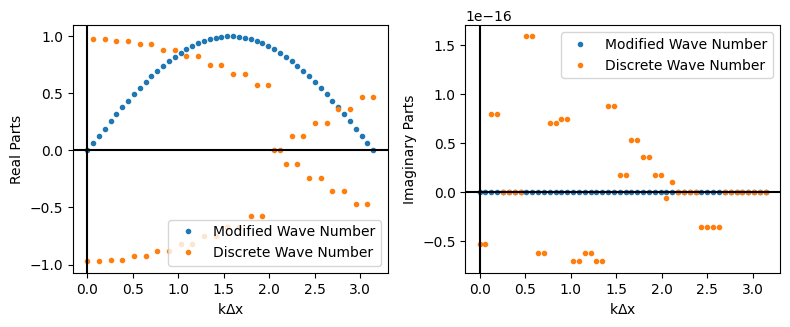

In [10]:
k = np.sin(kdx)
kN = - eigenvalues2 / (16 * np.pi  * 1j)

fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax1 = fig.add_subplot(221)
ax1.plot(kdx, np.real(k),'.', label = 'Modified Wave Number')
ax1.plot(kdx, np.real(kN), '.' ,label = 'Discrete Wave Number')

ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')


ax2 = fig.add_subplot(222)
ax2.plot(kdx, np.imag(k),'.',label = 'Modified Wave Number')
ax2.plot(kdx, np.imag(kN), '.',label = 'Discrete Wave Number')
ax2.axhline(y=0, color='k')
ax2.axvline(x=0, color='k')

ax1.set_xlabel('k$\Delta$x')
ax1.set_ylabel('Real Parts')
ax2.set_xlabel('k$\Delta$x')
ax2.set_ylabel('Imaginary Parts')
ax1.legend()
ax2.legend()

For the third order upwind scheme

$$ \frac{\delta u}{\delta x} = \frac{2u_{i+1} + 3u_i - 6u_{i-1} + u_{i-2}}{6\Delta x} $$

We substitute

$$ u_i = e^{ikx} $$

to get

$$
\frac{\delta u}{\delta x} = \frac{2e^{ik(x+\Delta x)} + 3e^{ikx} - 6e^{ik(x-\Delta x)} + e^{ik(x-2\Delta x)}}{6\Delta x}
$$
$$
\frac{\delta u}{\delta x} = e^{ikx}(\frac{2e^{ik\Delta x} + 3 - 6e^{ik\Delta x} + e^{-2ik\Delta x}}{6\Delta x})
$$

The using Euler's Formula

$$\frac{\delta u}{\delta x} = e^{ikx} \frac{(2\cos(k\Delta x) + 2 i \sin{k \Delta x} + 3 - 6 \cos(k \Delta x) + 6 \sin(k \Delta x) + \cos(2k \Delta x) - i \sin(2k \Delta x)}{6\Delta x} $$


$$\frac{\delta u}{\delta x} = e^{ikx} \frac{(-4\cos(k\Delta x) + 8 i \sin{k \Delta x} + \cos(2k \Delta x) - i \sin(2k \Delta x) + 3}{6\Delta x} $$


Therefore the modified wave number is:
$$ k^* = \frac{(-4\cos(k\Delta x) + 8 i \sin{k \Delta x} + \cos(2k \Delta x) - i \sin(2k \Delta x) + 3}{6i\Delta x} $$

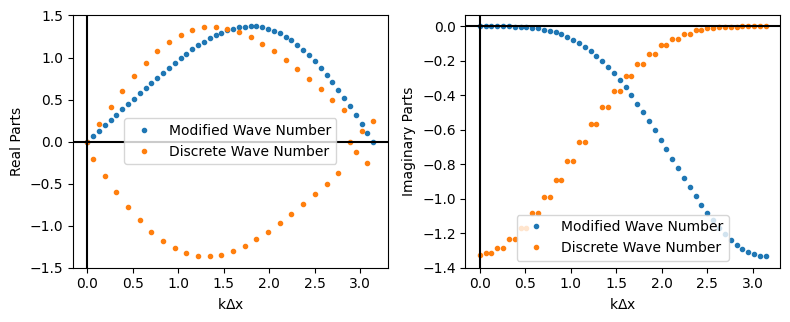

In [11]:
k = (3-4*np.cos(kdx) + 8j*np.sin(kdx) + np.cos(2 * kdx) - 1j * np.sin(2*kdx)) / (6j)
kN = - eigenvalues3 / (16 * np.pi  * 1j)

fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax1 = fig.add_subplot(221)
ax1.plot(kdx, np.real(k),'.', label = 'Modified Wave Number')
ax1.plot(kdx, np.real(kN), '.' ,label = 'Discrete Wave Number')

ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')


ax2 = fig.add_subplot(222)
ax2.plot(kdx, np.imag(k),'.',label = 'Modified Wave Number')
ax2.plot(kdx, np.imag(kN), '.',label = 'Discrete Wave Number')
ax2.axhline(y=0, color='k')
ax2.axvline(x=0, color='k')

ax1.set_xlabel('k$\Delta$x')
ax1.set_ylabel('Real Parts')
ax2.set_xlabel('k$\Delta$x')
ax2.set_ylabel('Imaginary Parts')
ax1.legend()
ax2.legend()

For the fourth order scheme we can follow the similar steps as above:

$$\frac{\delta u}{\delta x} = \frac{-u_{i+2}+8u_{i+1} - 8u_{i-1} +u_{i-2}}{12\Delta x}$$


substituting in the error analysis term:


$$\frac{\delta u}{\delta x} = \frac{-e^{ik(x+2\Delta x)}+8e^{ik(x+\Delta x)} - 8e^{ik(x-\Delta x)} +e^{ik(x-2\Delta x)}}{12\Delta x}$$

$$\frac{\delta u}{\delta x} = e^{ikx}\frac{-e^{ik2\Delta x}+8e^{ik\Delta x} - 8e^{ik\Delta x} +e^{-2ik\Delta x}}{12\Delta x}$$

With algebra and Eulers formula we can get:


$$\frac{\delta u}{\delta x} = e^{ikx} i \frac{8\sin(k\Delta x) - \sin(2k\Delta x)}{6\Delta x}$$

Therefore the modified wave number is:

$$k^* = \frac{8\sin(k\Delta x) - \sin(2k\Delta x)}{6\Delta x}$$


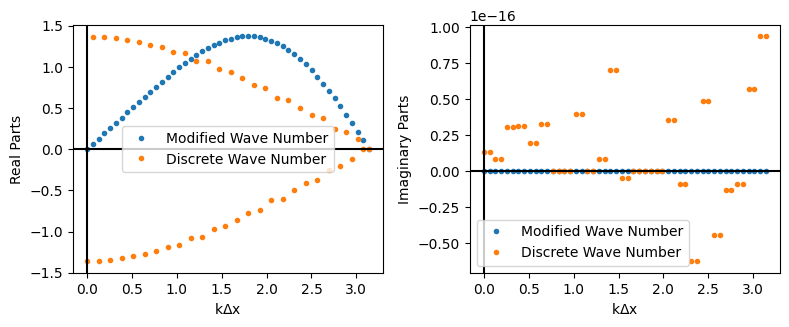

In [13]:
k = (8*np.sin(kdx)-np.sin(2*kdx)) / (6)
kN = - eigenvalues4 / (16 * np.pi  * 1j)

fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax1 = fig.add_subplot(221)
ax1.plot(kdx, np.real(k),'.', label = 'Modified Wave Number')
ax1.plot(kdx, np.real(kN), '.' ,label = 'Discrete Wave Number')

ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')


ax2 = fig.add_subplot(222)
ax2.plot(kdx, np.imag(k),'.',label = 'Modified Wave Number')
ax2.plot(kdx, np.imag(kN), '.',label = 'Discrete Wave Number')
ax2.axhline(y=0, color='k')
ax2.axvline(x=0, color='k')

ax1.set_xlabel('k$\Delta$x')
ax1.set_ylabel('Real Parts')
ax2.set_xlabel('k$\Delta$x')
ax2.set_ylabel('Imaginary Parts')
ax1.legend()
ax2.legend()

In [17]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# For use in Colab.  For local, just use jupyter nbconvert directly

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/AE410" # @param {type:"string"}
NOTEBOOK_NAME = "AE410HW3.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")

Mounted at /content/drive/
PDF CREATED: /content/drive/My Drive/AE410/AE410HW3.pdf
